In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
import datetime as dt
import torch
from sklearn.model_selection import train_test_split
import os

In [3]:
# Set the seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
# Check for GPU availability
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Selected device:", DEVICE)

Selected device: cpu


In [5]:
# Define file paths
TRAIN_FILE_PATH = 'fraudTrain.csv'
TEST_FILE_PATH = 'fraudTest.csv'

In [6]:
# Load datasets
train_df = pd.read_csv(TRAIN_FILE_PATH)
test_df = pd.read_csv(TEST_FILE_PATH)

In [7]:
# Combine train and test datasets
train_df['split'] = 'train'
test_df['split'] = 'test'
combined_df = pd.concat([train_df, test_df], axis=0)

In [8]:
# Convert date columns to datetime format
combined_df['trans_date_trans_time'] = pd.to_datetime(combined_df['trans_date_trans_time'])
combined_df['dob'] = pd.to_datetime(combined_df['dob'])

In [9]:
# Clean categorical columns
categorical_cols = combined_df.select_dtypes(include='object').columns
for col in categorical_cols:
    combined_df[col] = combined_df[col].str.lower().str.strip()

In [10]:
# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'street', 'merchant', 'zip', 'first', 'last', 'trans_num', 'job']
combined_df.drop(columns=columns_to_drop, inplace=True)

In [11]:
# Feature Engineering
combined_df['trans_hour'] = combined_df['trans_date_trans_time'].dt.hour
combined_df['trans_month'] = combined_df['trans_date_trans_time'].dt.month
combined_df['trans_dayofweek'] = combined_df['trans_date_trans_time'].dt.day_name()

In [12]:
# Transaction sorting
combined_df.sort_values(by=['cc_num', 'unix_time'], inplace=True)
combined_df['unix_time_prev_trans'] = combined_df.groupby('cc_num')['unix_time'].shift(1)
combined_df['unix_time_prev_trans'].fillna(combined_df['unix_time'] - 86400, inplace=True)
combined_df['timedelta_last_trans'] = (combined_df['unix_time'] - combined_df['unix_time_prev_trans']) // 60

In [13]:
# Location-based features
combined_df['lat_dist_cust_merch'] = (combined_df['lat'] - combined_df['merch_lat']).abs()
combined_df['long_dist_cust_merch'] = (combined_df['long'] - combined_df['merch_long']).abs()
combined_df['prev_merch_lat'] = combined_df.groupby('cc_num')['merch_lat'].shift(1).fillna(combined_df['merch_lat'])
combined_df['prev_merch_long'] = combined_df.groupby('cc_num')['merch_long'].shift(1).fillna(combined_df['merch_long'])
combined_df['lat_dist_prev_merch'] = (combined_df['merch_lat'] - combined_df['prev_merch_lat']).abs()
combined_df['long_dist_prev_merch'] = (combined_df['merch_long'] - combined_df['prev_merch_long']).abs()

In [14]:
# Summary of transaction counts per card
transaction_summary = combined_df.groupby('cc_num')['cc_num'].count().describe()

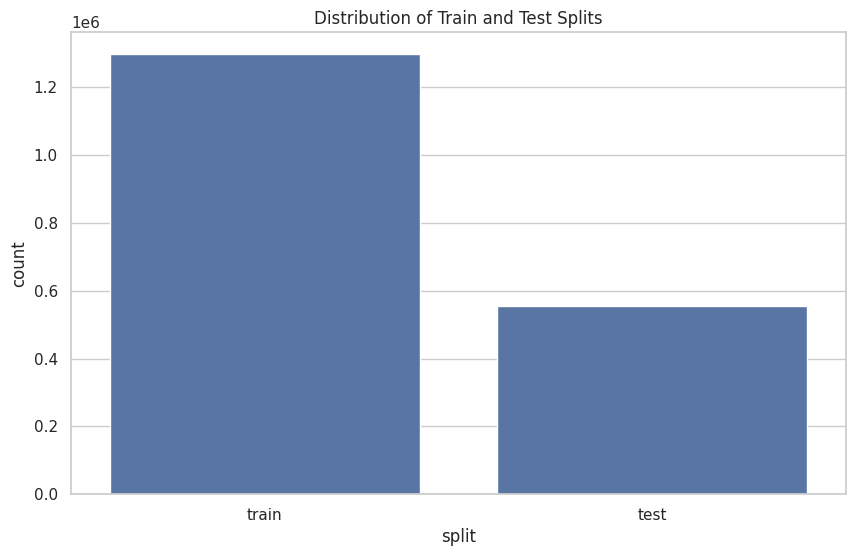

In [15]:
# Plot distributions
sns.set(style="whitegrid", rc={'figure.figsize': (15, 8)})
plt.figure(figsize=(10, 6))
sns.countplot(x='split', data=combined_df)
plt.title('Distribution of Train and Test Splits')
plt.show()

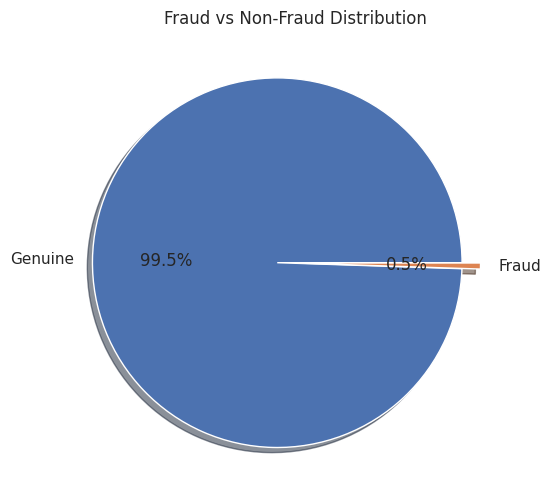

In [16]:
fraud_distribution = combined_df['is_fraud'].value_counts(normalize=True) * 100
plt.figure(figsize=(10, 6))
plt.pie(fraud_distribution, labels=['Genuine', 'Fraud'], autopct='%1.1f%%', explode=[0.1, 0], shadow=True)
plt.title('Fraud vs Non-Fraud Distribution')
plt.show()

In [17]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv('fraudTrain.csv')
test_df = pd.read_csv('fraudTest.csv')

# Convert the date columns to datetime format
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
train_df['dob'] = pd.to_datetime(train_df['dob'], format='%d/%m/%y', errors='coerce')

test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
test_df['dob'] = pd.to_datetime(test_df['dob'], format='%d/%m/%y', errors='coerce')

# Calculate the age
train_df['cust_age'] = (train_df['trans_date_trans_time'] - train_df['dob']).dt.days / 365.25
test_df['cust_age'] = (test_df['trans_date_trans_time'] - test_df['dob']).dt.days / 365.25

# Display the updated DataFrames
print("Training DataFrame with Age:")
print(train_df.head())

print("\nTesting DataFrame with Age:")
print(test_df.head())


Training DataFrame with Age:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      long city_pop  \
0    Banks      F                561 Perry Cove  ...  -81.1781     3495   
1     Gill      F  43039 Ri

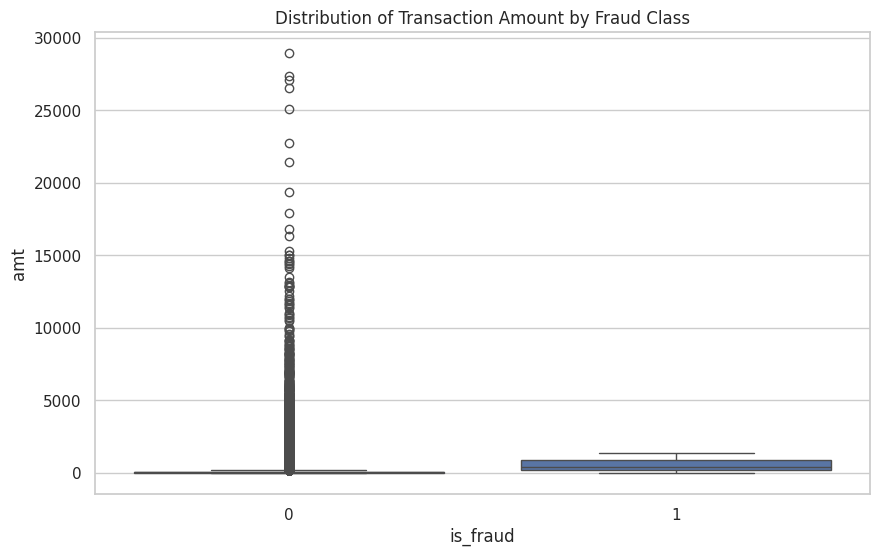

In [18]:
# Distribution of amount
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amt', data=combined_df)
plt.title('Distribution of Transaction Amount by Fraud Class')
plt.show()

fraudTest.csv columns: Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
fraudTrain.csv columns: Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
Combined DataFrame columns: Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
The 'gender' column is present.

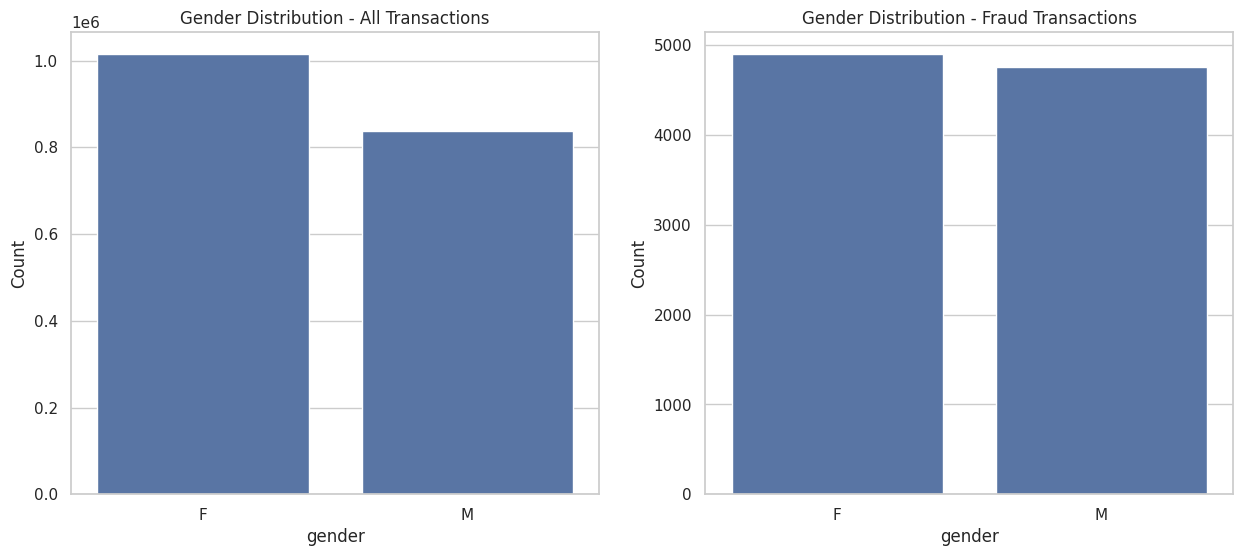

In [19]:
# Gender distribution
import pandas as pd

# Load the datasets
fraud_test = pd.read_csv('fraudTest.csv')
fraud_train = pd.read_csv('fraudTrain.csv')

# Check columns in each dataset
print("fraudTest.csv columns:", fraud_test.columns)
print("fraudTrain.csv columns:", fraud_train.columns)

# Combine the datasets
combined_df = pd.concat([fraud_test, fraud_train], ignore_index=True)

# Check columns in the combined DataFrame
print("Combined DataFrame columns:", combined_df.columns)

# Check for and remove any leading/trailing spaces in column names
combined_df.columns = combined_df.columns.str.strip()

# Verify 'gender' column existence
if 'gender' in combined_df.columns:
    print("The 'gender' column is present.")
else:
    print("The 'gender' column is missing.")

# Proceed with gender distribution if 'gender' column is present
if 'gender' in combined_df.columns:
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Gender distribution for all transactions
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.barplot(x=combined_df['gender'].value_counts().index, y=combined_df['gender'].value_counts(), ax=axes[0])
    axes[0].set_title('Gender Distribution - All Transactions')
    axes[0].set_ylabel('Count')

    # Gender distribution for fraud transactions
    fraud_gender_distribution = combined_df[combined_df['is_fraud'] == 1]['gender'].value_counts()
    sns.barplot(x=fraud_gender_distribution.index, y=fraud_gender_distribution, ax=axes[1])
    axes[1].set_title('Gender Distribution - Fraud Transactions')
    axes[1].set_ylabel('Count')

    plt.show()


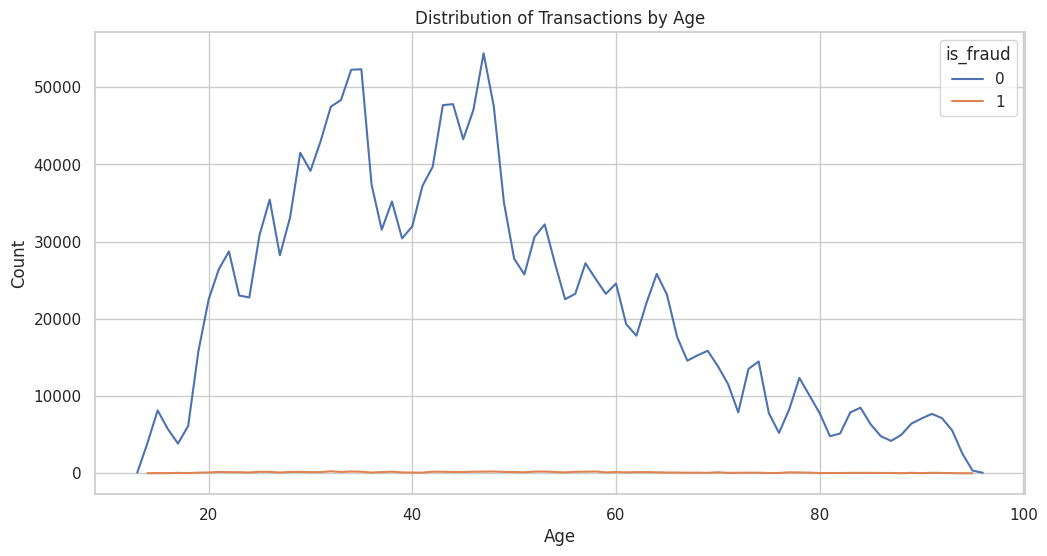

In [20]:
# Age vs Fraud Class

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
fraud_test = pd.read_csv('fraudTest.csv')
fraud_train = pd.read_csv('fraudTrain.csv')

# Combine the datasets
combined_df = pd.concat([fraud_test, fraud_train], ignore_index=True)

# Strip any leading/trailing spaces from column names
combined_df.columns = combined_df.columns.str.strip()

# Convert 'trans_date_trans_time' to datetime with automatic format detection
combined_df['trans_date_trans_time'] = pd.to_datetime(combined_df['trans_date_trans_time'], errors='coerce')

# Convert 'dob' to datetime with flexible parsing
combined_df['dob'] = pd.to_datetime(combined_df['dob'], errors='coerce')

# Check if there are any null values in 'dob'
if combined_df['dob'].isnull().any():
    print("\nRemaining problematic entries in 'dob':")
    print(combined_df[combined_df['dob'].isnull()])

# Calculate the customer's age
# Use .dt.year to get the year difference
combined_df['cust_age'] = combined_df['trans_date_trans_time'].dt.year - combined_df['dob'].dt.year

# Correct for cases where the birthday hasn't occurred yet this year
combined_df['cust_age'] -= ((combined_df['trans_date_trans_time'].dt.month < combined_df['dob'].dt.month) |
                            ((combined_df['trans_date_trans_time'].dt.month == combined_df['dob'].dt.month) &
                             (combined_df['trans_date_trans_time'].dt.day < combined_df['dob'].dt.day))).astype(int)

# Ensure the 'cust_age' column is calculated
if 'cust_age' not in combined_df.columns:
    raise ValueError("The 'cust_age' column is missing from combined_df.")

# Group by 'cust_age' and 'is_fraud', and count the occurrences
age_fraud_distribution = combined_df.groupby(['cust_age', 'is_fraud']).size().reset_index(name='count')

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.lineplot(data=age_fraud_distribution, x='cust_age', y='count', hue='is_fraud')
plt.title('Distribution of Transactions by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


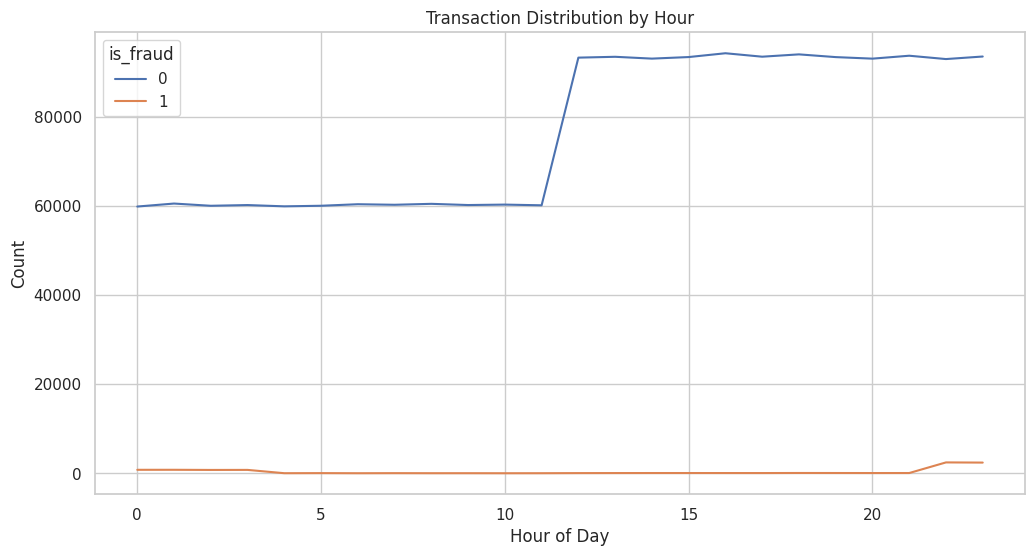

In [21]:
# Transaction Hour Analysis


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
fraud_test = pd.read_csv('fraudTest.csv')
fraud_train = pd.read_csv('fraudTrain.csv')

# Combine the datasets
combined_df = pd.concat([fraud_test, fraud_train], ignore_index=True)

# Strip any leading/trailing spaces from column names
combined_df.columns = combined_df.columns.str.strip()

# Convert 'trans_date_trans_time' to datetime
combined_df['trans_date_trans_time'] = pd.to_datetime(combined_df['trans_date_trans_time'], errors='coerce')

# Extract hour from 'trans_date_trans_time'
combined_df['trans_hour'] = combined_df['trans_date_trans_time'].dt.hour

# Group by 'trans_hour' and 'is_fraud', and count the occurrences
hourly_distribution = combined_df.groupby(['trans_hour', 'is_fraud']).size().reset_index(name='count')

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_distribution, x='trans_hour', y='count', hue='is_fraud')
plt.title('Transaction Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.show()


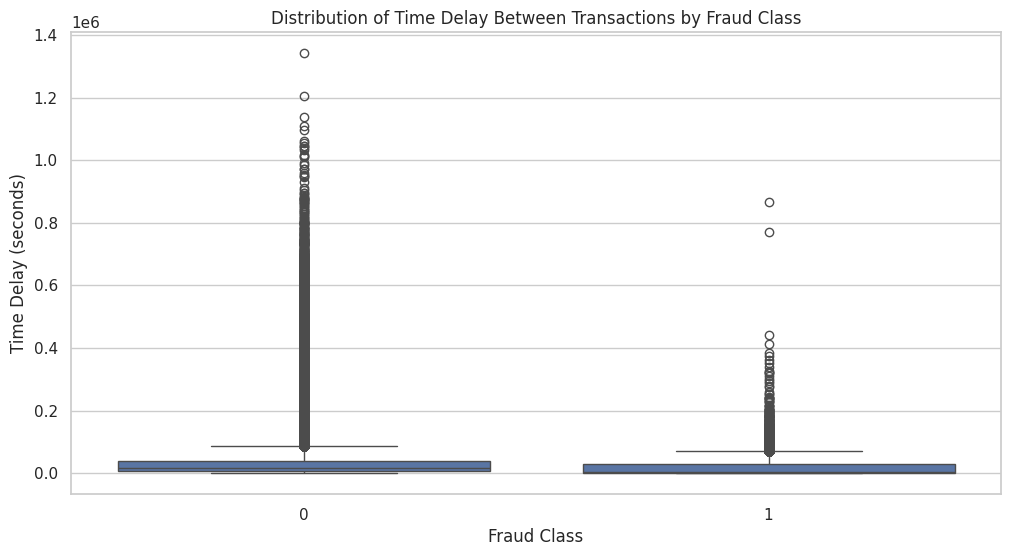

In [22]:
# Delay between transactions


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
fraud_test = pd.read_csv('fraudTest.csv')
fraud_train = pd.read_csv('fraudTrain.csv')

# Combine the datasets
combined_df = pd.concat([fraud_test, fraud_train], ignore_index=True)

# Strip any leading/trailing spaces from column names
combined_df.columns = combined_df.columns.str.strip()

# Convert 'trans_date_trans_time' to datetime
combined_df['trans_date_trans_time'] = pd.to_datetime(combined_df['trans_date_trans_time'], errors='coerce')

# Sort by user and transaction time
combined_df = combined_df.sort_values(by=['cc_num', 'trans_date_trans_time'])

# Calculate time difference between consecutive transactions for each user
combined_df['timedelta_last_trans'] = combined_df.groupby('cc_num')['trans_date_trans_time'].diff()

# Convert the time difference to seconds (or other unit if preferred)
combined_df['timedelta_last_trans'] = combined_df['timedelta_last_trans'].dt.total_seconds()

# Plot the distribution of time delays by fraud class
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_fraud', y='timedelta_last_trans', data=combined_df)
plt.title('Distribution of Time Delay Between Transactions by Fraud Class')
plt.xlabel('Fraud Class')
plt.ylabel('Time Delay (seconds)')
plt.show()


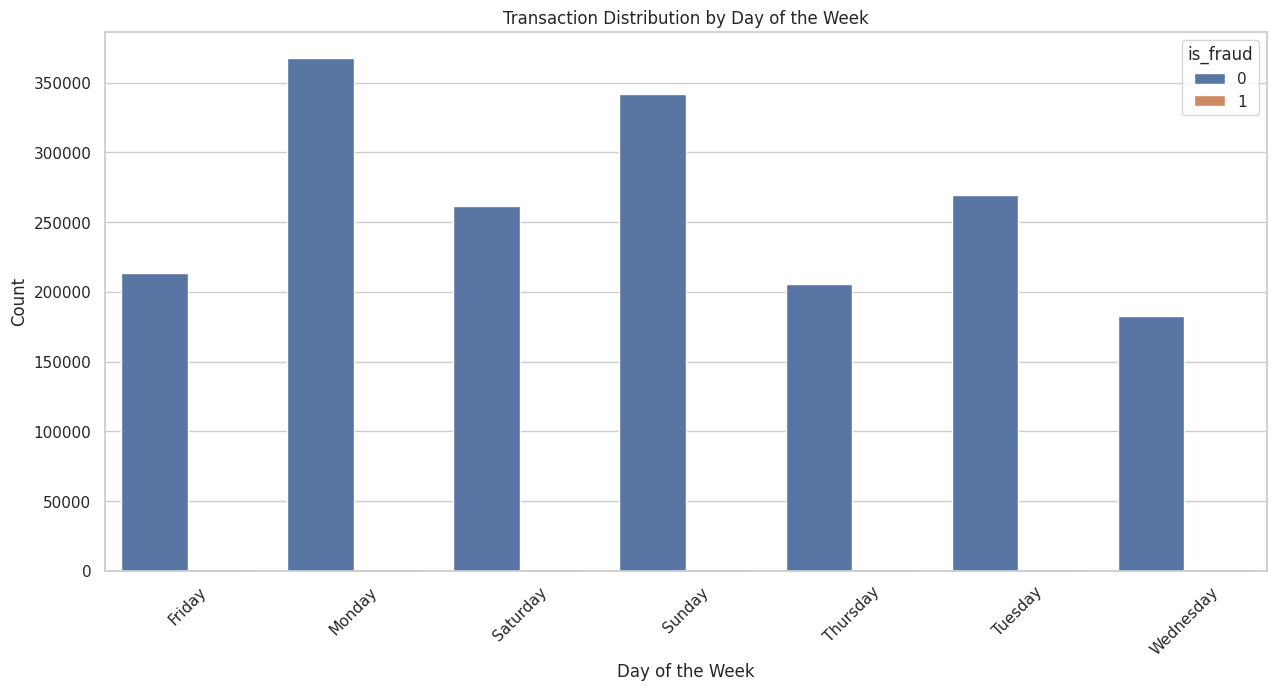

In [23]:
# Day of the Week Analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
fraud_test = pd.read_csv('fraudTest.csv')
fraud_train = pd.read_csv('fraudTrain.csv')

# Combine the datasets
combined_df = pd.concat([fraud_test, fraud_train], ignore_index=True)

# Strip any leading/trailing spaces from column names
combined_df.columns = combined_df.columns.str.strip()

# Convert 'trans_date_trans_time' to datetime
combined_df['trans_date_trans_time'] = pd.to_datetime(combined_df['trans_date_trans_time'], errors='coerce')

# Create 'trans_dayofweek' column
combined_df['trans_dayofweek'] = combined_df['trans_date_trans_time'].dt.day_name()

# Group by day of the week and fraud status
day_distribution = combined_df.groupby(['trans_dayofweek', 'is_fraud']).size().reset_index(name='count')

# Plot the distribution
plt.figure(figsize=(15, 7))
sns.barplot(data=day_distribution, x='trans_dayofweek', y='count', hue='is_fraud')
plt.title('Transaction Distribution by Day of the Week')
plt.xticks(rotation=45)
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.show()


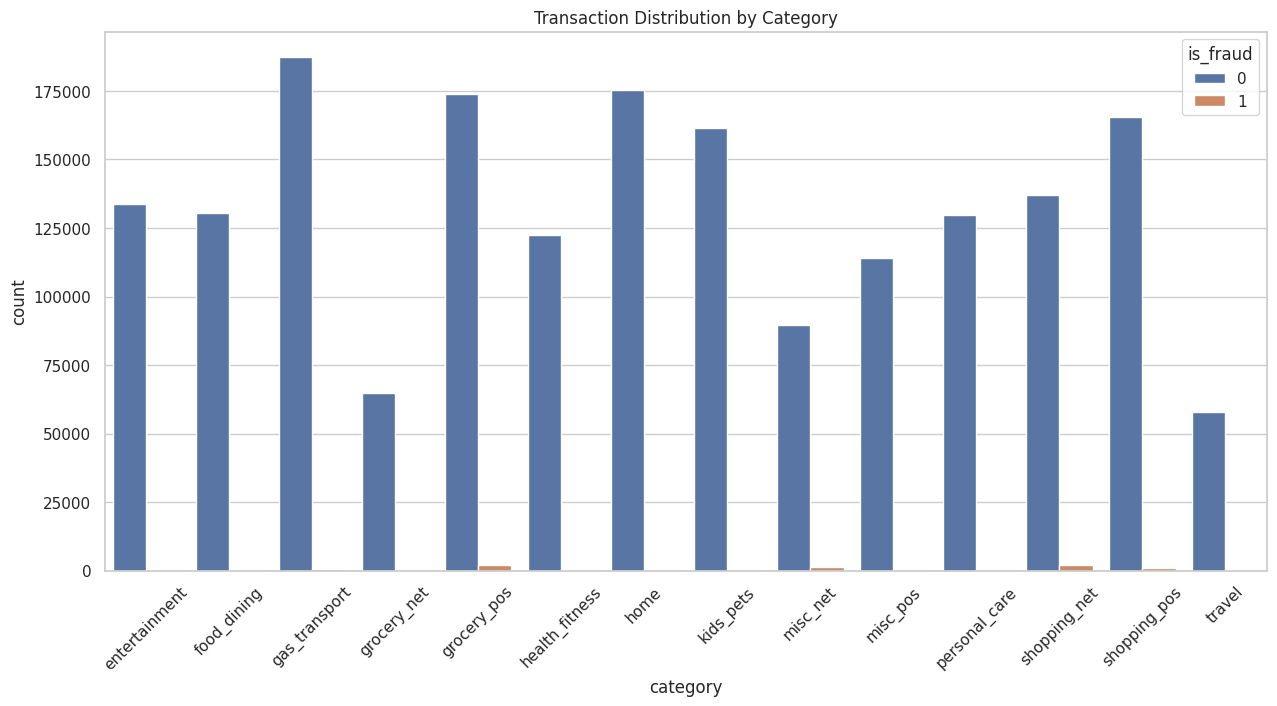

In [24]:
# Category of Items
plt.figure(figsize=(15, 7))
category_distribution = combined_df.groupby(['category', 'is_fraud']).size().reset_index(name='count')
sns.barplot(data=category_distribution, x='category', y='count', hue='is_fraud')
plt.title('Transaction Distribution by Category')
plt.xticks(rotation=45)
plt.show()

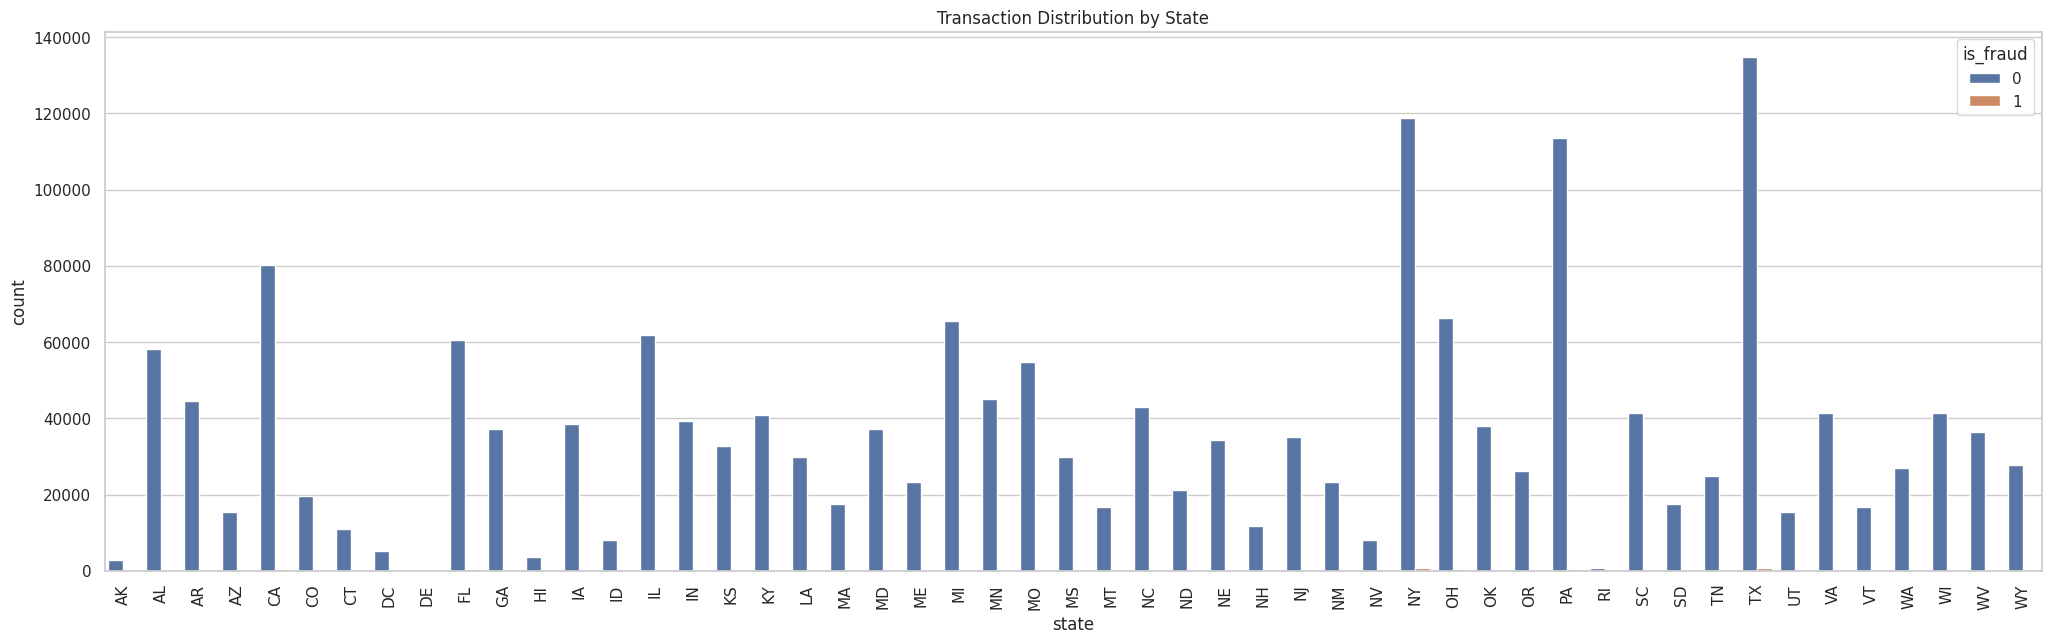

In [25]:
# State Analysis
plt.figure(figsize=(25, 7))
state_distribution = combined_df.groupby(['state', 'is_fraud']).size().reset_index(name='count')
sns.barplot(data=state_distribution, x='state', y='count', hue='is_fraud')
plt.title('Transaction Distribution by State')
plt.xticks(rotation=90)
plt.show()